In [ ]:
#
#   Imports
#
from sys import argv
import time
from typing import Any, Dict, List
from pathlib import Path



import pandas as pd
import requests
from tqdm import tqdm

pd.options.display.max_columns = 999
pd.options.display.max_rows = 1999
pd.options.display.max_colwidth = 200
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:

#
#   Constants
#
API_URL = "https://randomuser.me/api/"


def get_user() -> Dict[str, Any]:
    """
    Fetches a random-generated user from the randomuser.me API.
    """
    try:
        # Make a GET request to the API
        response = requests.get(API_URL)
        # Raise an exception if the request fails
        response.raise_for_status()
        # Parse the response as JSON and return the result
        return response.json()["results"][0]
    except requests.exceptions.HTTPError as err:
        print(err)
        # return None


def get_users(n: int) -> List[Dict[str, Any]]:
    """
    Fetches a list of random-generated users from the randomuser.me API.
    """
    users = []
    for _ in tqdm(range(n), desc="Fetching users"):
        user = get_user()
        if user is not None:
            users.append(user)
    return users


def get_users_df(n: int) -> pd.DataFrame:
    """
    Fetches a list of random-generated users from the randomuser.me API and
    returns a pandas DataFrame.
    """
    users = get_users(n)
    df = pd.json_normalize(users, sep="_")
    return df




In [ ]:
n = 1000
df = get_users_df(n)

In [106]:
def padronize_phone_number(df,col,phone_len):
    df[col] = (
        df[col]
        .str.replace(")", "")
        .str.replace("(", "")
        .str.replace(" ", "")
        .str.replace("-", "")
    )
    return (
        df[col]
        .str.zfill(phone_len)
        .apply(lambda x: "(" + x[:2] + ")" + x[2:8] + "-" + x[8:])
        )

In [109]:
df['phone'] = padronize_phone_number(df,'phone',14)
df['cell'] = padronize_phone_number(df,'cell',14)

<ipython-input-106-d89510f3e6e3>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df[col]


In [31]:
df['gender'].value_counts(normalize=True)

female    0.501071
male      0.498929
Name: gender, dtype: float64

In [38]:
df['location_country'].value_counts(normalize=True) * 100

United Kingdom    5.781585
Mexico            5.781585
Norway            5.674518
Canada            5.674518
Iran              5.460385
France            5.353319
Finland           5.246253
Spain             5.032120
New Zealand       5.032120
Ireland           4.925054
Australia         4.817987
India             4.710921
United States     4.603854
Ukraine           4.389722
Brazil            4.282655
Denmark           4.175589
Germany           4.068522
Serbia            4.068522
Turkey            4.068522
Netherlands       3.747323
Switzerland       3.104925
Name: location_country, dtype: float64

In [118]:
df["count"] = 1
df[["location_country", "location_state", "count"]].groupby(
    by=["location_country", "location_state"],
    as_index=False,
).sum()

,location_country,location_state,count
0,Australia,Australian Capital Territory,5
1,Australia,New South Wales,8
2,Australia,Northern Territory,4
3,Australia,Queensland,6
4,Australia,South Australia,4
5,Australia,Tasmania,5
6,Australia,Victoria,6
7,Australia,Western Australia,7
8,Brazil,Acre,3
9,Brazil,Amazonas,1


<AxesSubplot:ylabel='Frequency'>

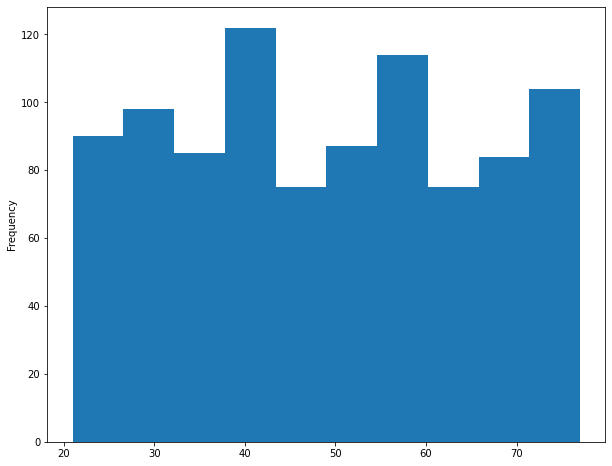

In [57]:
df["dob_age"].plot.hist(figsize=(10, 8))


In [59]:
# Salvar dados no formato de particao 
# ./data/location_country=value/location_state=value/gender=value
# a coluna das particoes nao devem estar no csv final 

In [123]:
to_partitions(df,['location_country','location_state'], './data/')

import shutil

shutil.rmtree('data/')

In [122]:


def to_partitions(
    data: pd.DataFrame,
    partition_columns: List[str],
    savepath: str,
    data_type: str = "csv",
    suffix: str = None,
):  # sourcery skip: raise-specific-error
    """Save data in to hive patitions schema, given a dataframe and a list of partition columns.
    Args:
        data (pandas.core.frame.DataFrame): Dataframe to be partitioned.
        partition_columns (list): List of columns to be used as partitions.
        savepath (str, pathlib.PosixPath): folder path to save the partitions
    Exemple:
        data = {
            "ano": [2020, 2021, 2020, 2021, 2020, 2021, 2021,2025],
            "mes": [1, 2, 3, 4, 5, 6, 6,9],
            "sigla_uf": ["SP", "SP", "RJ", "RJ", "PR", "PR", "PR","PR"],
            "dado": ["a", "b", "c", "d", "e", "f", "g",'h'],
        }
        to_partitions(
            data=pd.DataFrame(data),
            partition_columns=['ano','mes','sigla_uf'],
            savepath='partitions/'
        )
    """

    if isinstance(data, (pd.core.frame.DataFrame)):

        savepath = Path(savepath)

        # create unique combinations between partition columns
        unique_combinations = (
            data[partition_columns]
            .drop_duplicates(subset=partition_columns)
            .to_dict(orient="records")
        )

        for filter_combination in unique_combinations:
            patitions_values = [
                f"{partition}={value}"
                for partition, value in filter_combination.items()
            ]

            # get filtered data
            df_filter = data.loc[
                data[filter_combination.keys()]
                .isin(filter_combination.values())
                .all(axis=1),
                :,
            ]
            df_filter = df_filter.drop(columns=partition_columns).reset_index(drop=True)

            # create folder tree
            filter_save_path = Path(savepath / "/".join(patitions_values))
            filter_save_path.mkdir(parents=True, exist_ok=True)
            if suffix is not None:
                file_filter_save_path = (
                    Path(filter_save_path) / f"data_{suffix}.{data_type}"
                )
            else:
                file_filter_save_path = Path(filter_save_path) / f"data.{data_type}"
            if data_type == "csv":
                # append data to csv
                df_filter.to_csv(
                    file_filter_save_path,
                    index=False,
                    mode="a",
                    header=not file_filter_save_path.exists(),
                )
            elif data_type == "parquet":
                dataframe_to_parquet(dataframe=df_filter, path=file_filter_save_path)
            else:
                raise ValueError(f"Invalid data type: {data_type}")
    else:
        raise BaseException("Data need to be a pandas DataFrame")